# Load libraries and mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pygam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [ ]:
obs_pivot = pd.read_csv("/content/drive/MyDrive/obs/obs_pivot.csv")
obs_pivot.head()

,Date,NHDPlusID,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm
0,1980-01-01,55000900029021,0.007362,NaN,NaN,NaN,NaN,NaN
1,1980-01-01,55000900029608,0.350421,NaN,NaN,NaN,NaN,NaN
2,1980-01-01,55000900061097,3.369699,NaN,NaN,NaN,NaN,NaN
3,1980-01-01,55000900095919,0.003794,NaN,NaN,NaN,NaN,NaN
4,1980-01-01,55000900130309,0.045505,NaN,NaN,NaN,NaN,NaN


# Select top 10 sites by available discharge data to be the training set

In [ ]:
discharge_col = 'Discharge_CMS'
top_sites = obs_pivot[~obs_pivot[discharge_col].isna()]['NHDPlusID'].value_counts().index[:10]

top_sites

Index([55000900061097, 55000900029608, 55000900167704, 55000900130316,
       55000900130309, 55000900271031, 55000900234607, 55000900095919,
       55000900200040, 55000900029021],
      dtype='int64', name='NHDPlusID')

In [ ]:
training_df = obs_pivot[(obs_pivot['NHDPlusID'].isin(top_sites)) & (~obs_pivot[discharge_col].isna())].copy()
training_df['log_discharge'] = np.log(training_df[discharge_col])
training_df

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,NHDPlusID,Discharge_CMS,Flow_Status,HoboWetDry0.05,MaxDepth_Censor,MaxDepth_Threshold,MaxDepth_cm,log_discharge
0,1980-01-01,55000900029021,0.007362,NaN,NaN,NaN,NaN,NaN,-4.911372
1,1980-01-01,55000900029608,0.350421,NaN,NaN,NaN,NaN,NaN,-1.048620
2,1980-01-01,55000900061097,3.369699,NaN,NaN,NaN,NaN,NaN,1.214823
3,1980-01-01,55000900095919,0.003794,NaN,NaN,NaN,NaN,NaN,-5.574214
4,1980-01-01,55000900130309,0.045505,NaN,NaN,NaN,NaN,NaN,-3.089929
...,...,...,...,...,...,...,...,...,...
158598,2023-06-22,55000900061097,0.702257,NaN,NaN,NaN,NaN,NaN,-0.353456
158599,2023-06-23,55000900061097,0.673940,NaN,NaN,NaN,NaN,NaN,-0.394614
158600,2023-06-24,55000900061097,0.654118,NaN,NaN,NaN,NaN,NaN,-0.424467
158601,2023-06-25,55000900061097,0.637128,NaN,NaN,NaN,NaN,NaN,-0.450785


# Function to fit GAM and scale per site

In [ ]:
def predict_site_gam(df_site, target_col="Discharge_CMS", n_splines=50):
    """
    Predict discharge for a single site using a global seasonal GAM + site-specific scaling.

    Parameters:
        df_site : pd.DataFrame
            Must have columns ['Date', 'Discharge_CMS'] for a single site.
        n_splines : int
            Number of splines for the GAM (higher -> more flexible seasonal peaks)

    Returns:
        pd.DataFrame with ['Date','Discharge_CMS','seasonal','pred_flow']
    """

    df = df_site.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['doy'] = df['Date'].dt.dayofyear

    mask = df[target_col].notna() & np.isfinite(df[target_col])
    if mask.sum() == 0:
        df['seasonal'] = np.nan
        df['pred_flow'] = np.nan
        return df

    gam = LinearGAM(s(0, n_splines=n_splines)).fit(
        df.loc[mask, 'doy'].values.reshape(-1,1),
        df.loc[mask, target_col].values
    )

    df['seasonal'] = gam.predict(df['doy'].values.reshape(-1,1))

    A = np.vstack([np.ones(mask.sum()), df.loc[mask, 'seasonal']]).T
    y_obs = df.loc[mask, target_col].values
    a, b = np.linalg.lstsq(A, y_obs, rcond=None)[0]

    df['pred_flow'] = a + b * df['seasonal']
    df['pred_flow'] = np.maximum(df['pred_flow'], 0)

    return df

# Apply GAM to all sites


In [ ]:
discharge_df = obs_pivot[~obs_pivot['Discharge_CMS'].isna()]
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])
discharge_df['NHDPlusID'] = discharge_df['NHDPlusID'].astype(str)
discharge_df

def make_df(site):
    start_date = discharge_df['Date'].min()
    end_date   = discharge_df['Date'].max()
    df_site = discharge_df[discharge_df['NHDPlusID']==site][['Date','Discharge_CMS']]
    full_dates = pd.DataFrame({'Date': pd.date_range(start=start_date, end=end_date, freq='D')})
    df_full = full_dates.merge(df_site, on='Date', how='left')

    return df_full

/tmp/ipython-input-1051069705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])
/tmp/ipython-input-1051069705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_df['NHDPlusID'] = discharge_df['NHDPlusID'].astype(str)


In [ ]:
all_preds = []

for site in discharge_df['NHDPlusID'].value_counts().index:
    df_site = make_df(site)
    df_site = predict_site_gam(df_site)
    df_site['NHDPlusID'] = site
    all_preds.append(df_site)

predictions_df_gam = pd.concat(all_preds, ignore_index=True)
predictions_df_gam['combined_prediction'] = predictions_df_gam['Discharge_CMS'].fillna(predictions_df_gam['pred_flow'])
display(predictions_df_gam.head())

/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:804: RuntimeWarning: divide by zero encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:804: RuntimeWarning: invalid value encountered in scalar divide
  diff = np.linalg.norm(self.coef_ - coef_new) / np.linalg.norm(coef_new)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_distn_infrastructure.py:2106: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.12/dist-packages/pygam/distributions.py:184: RuntimeWarning: invalid value encountered in divide
  dev /= self.scale**2
/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:1292: RuntimeWarning: invalid value encountered in scalar divide
  score = score / rank


did not converge


/usr/local/lib/python3.12/dist-packages/pygam/pygam.py:1150: RuntimeWarning: divide by zero encountered in scalar divide
  r2["explained_deviance"] = 1.0 - full_d.sum() / null_d.sum()


,Date,Discharge_CMS,doy,seasonal,pred_flow,NHDPlusID,combined_prediction
0,1980-01-01,3.369699,1,5.940913,5.946411,55000900061097,3.369699
1,1980-01-02,3.171482,2,5.820453,5.825703,55000900061097,3.171482
2,1980-01-03,3.539600,3,5.775028,5.780184,55000900061097,3.539600
3,1980-01-04,3.596234,4,5.792863,5.798056,55000900061097,3.596234
4,1980-01-05,11.439987,5,5.862185,5.867521,55000900061097,11.439987


# Plot predictions

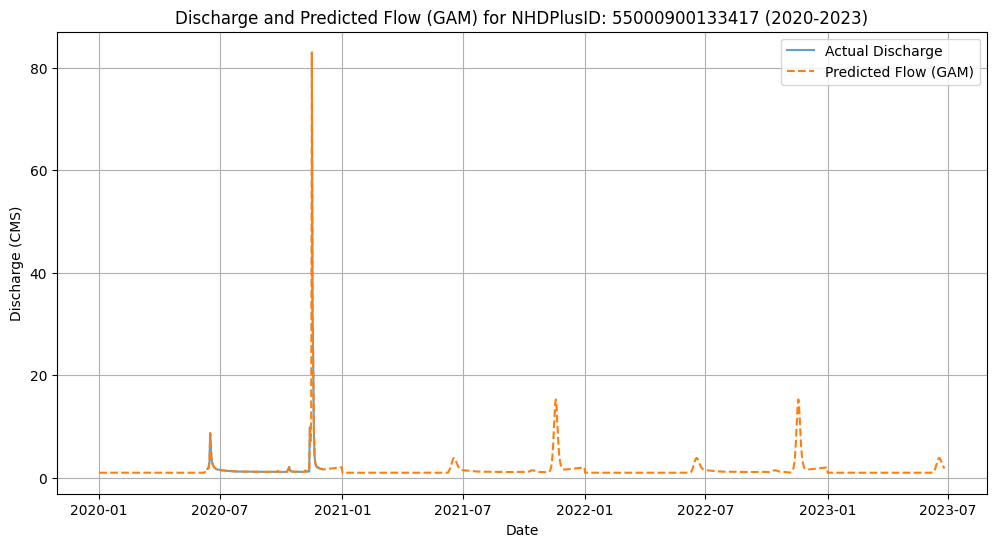

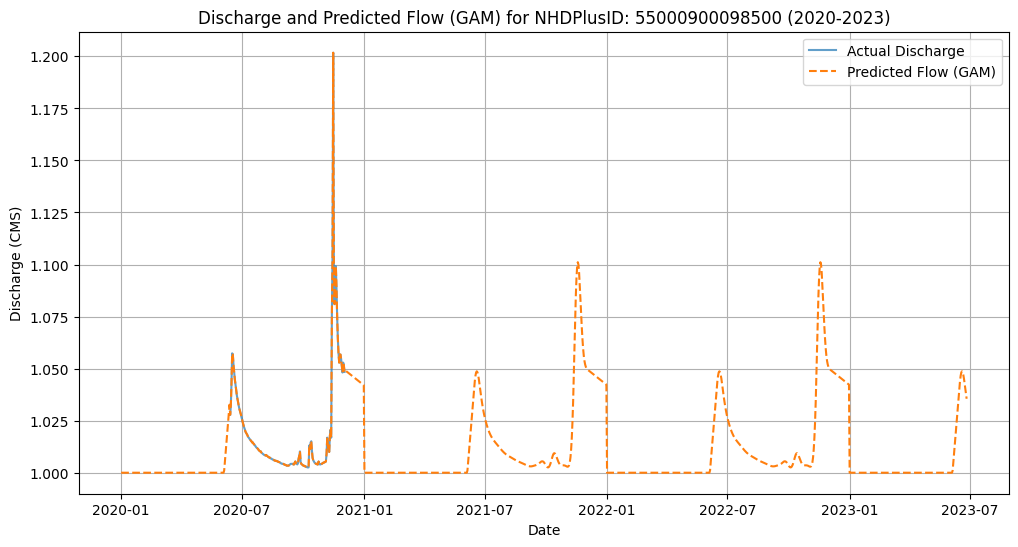

In [ ]:
def plot_prediction(df, site_id, target_col='Discharge_CMS', start_year=2020, end_year=2023):
    site_data = df[(df['NHDPlusID'] == site_id) &
                   (df['Date'].dt.year >= start_year) &
                   (df['Date'].dt.year <= end_year)]

    plt.figure(figsize=(12, 6))
    plt.plot(site_data['Date'], np.exp(site_data[target_col]), label='Actual Discharge', alpha=0.7)
    plt.plot(site_data['Date'], np.exp(site_data['combined_prediction']), label='Predicted Flow (GAM)', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Discharge (CMS)')
    plt.title(f'Discharge and Predicted Flow (GAM) for NHDPlusID: {site_id} ({start_year}-{end_year})')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_prediction(predictions_df_gam, "55000900133417")
plot_prediction(predictions_df_gam, "55000900098500")